# Pearson Residues Example
**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/dli_census.h5ad")

CPU times: user 354 ms, sys: 1.36 s, total: 1.71 s
Wall time: 1.71 s


In [5]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 158 ms, sys: 2.23 s, total: 2.38 s
Wall time: 2.38 s


In [6]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 4.109776496887207


## Preprocessing

In [7]:
preprocess_start = time.time()

In [8]:
adata.var_names = adata.var.feature_name

### Quality Control

We calculate quality control (QC) metrics to assess cell and gene quality. These include:  

- **Per cell metrics**:  
  - Total counts per cell (library size)  
  - Number of detected genes per cell  
  - Percentage of counts from mitochondrial (`MT`) and ribosomal (`RIBO`) genes  

- **Per gene metrics** (gene space):  
  - Total counts per gene  
  - Number of cells expressing each gene  

These metrics help identify low-quality or stressed cells and ensure a meaningful feature set for downstream analysis.

In [9]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 6.71 ms, sys: 0 ns, total: 6.71 ms
Wall time: 6.65 ms


In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 6.2 ms, sys: 103 μs, total: 6.31 ms
Wall time: 6.22 ms


In [11]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 70.1 ms, sys: 8.1 ms, total: 78.2 ms
Wall time: 77.7 ms


To visualize the quality control (QC) metrics, we generate the following plots:

1. **Scatter plot: Total counts vs. Mitochondrial percentage**  
   - This plot shows the relationship between the total UMI counts per cell and the percentage of mitochondrial (`MT`) gene expression.  
   - Cells with high mitochondrial percentages may indicate stressed or dying cells.

2. **Scatter plot: Total counts vs. Number of detected genes**  
   - This plot displays the correlation between the total UMI counts per cell and the number of detected genes.  
   - A strong correlation is expected, but outliers with low gene counts might indicate empty droplets or dead cells.

3. **Violin plot: Number of detected genes per cell**  
   - This violin plot visualizes the distribution of the number of detected genes per cell.  
   - It helps identify cells with abnormally low or high gene counts, which could be filtered out.

4. **Violin plot: Total counts per cell**  
   - This plot shows the distribution of total counts per cell, indicating library size variation.  
   - Extreme values may suggest low-quality or overly dominant cells.

5. **Violin plot: Percentage of mitochondrial counts per cell**  
   - This plot illustrates the distribution of mitochondrial gene expression across all cells.  
   - High mitochondrial content could be a sign of cell stress or apoptosis.

These visualizations help assess dataset quality and guide decisions on filtering low-quality cells.

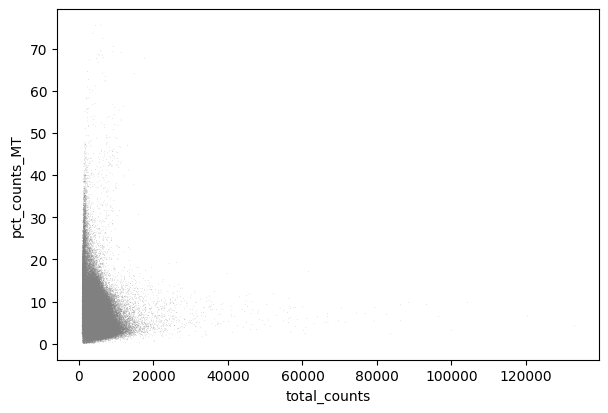

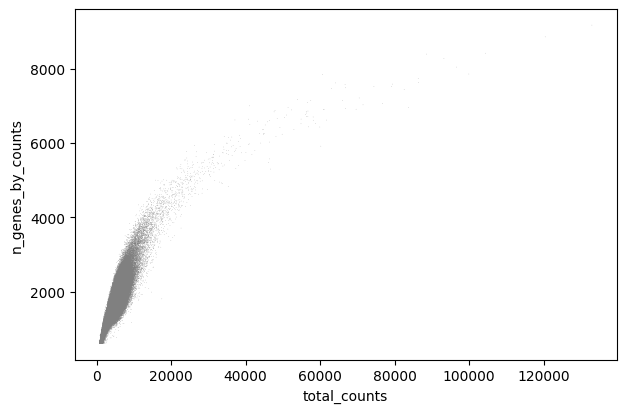

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

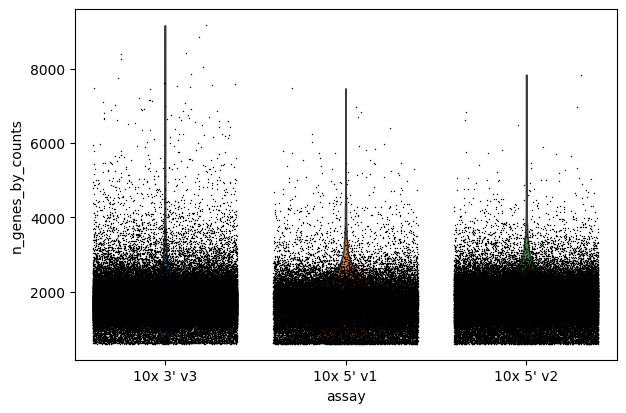

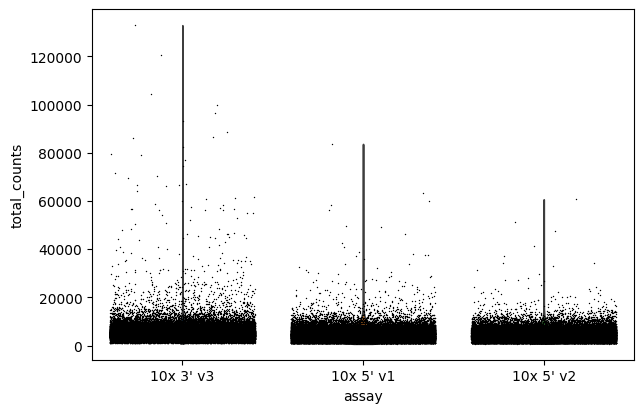

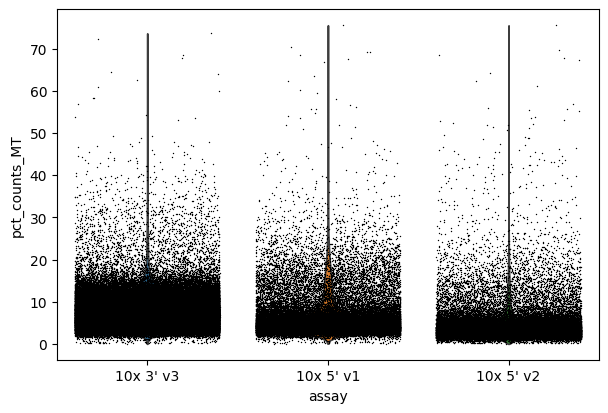

In [13]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="assay")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="assay")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [14]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata = adata[adata.obs["pct_counts_MT"] < 20]

CPU times: user 128 ms, sys: 16.2 ms, total: 144 ms
Wall time: 143 ms


We also filter out genes that are expressed in less than 3 cells.

In [15]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 33823 genes that are detected in less than 3 cells
CPU times: user 392 ms, sys: 101 ms, total: 493 ms
Wall time: 625 ms


The size of our count matrix is now reduced.

In [16]:
adata.shape

(213082, 28065)

### Normalize

Before performing further transformations on the data, we store the **raw count matrix** in the `.layers` attribute.  
This ensures that the original unnormalized expression values remain accessible for later analyses.  


In [17]:
adata.layers["counts"] = adata.X.copy()

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [18]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 1.78 ms, sys: 97 μs, total: 1.87 ms
Wall time: 1.41 ms


Next, we data transform the count matrix.

In [19]:
%%time
rsc.pp.log1p(adata)

CPU times: user 35.6 ms, sys: 19.1 ms, total: 54.6 ms
Wall time: 54.1 ms


In [20]:
adata.raw = adata

### **Identifying Highly Variable Genes**  

Next, we identify **highly variable genes (HVGs)**, which capture the most biologically relevant variation in the dataset.  
These genes are selected based on their variance, helping to reduce noise and focus on meaningful signals.  

We use the **Pearson residuals** method to detect HVGs while preserving statistical robustness


In [21]:
%%time
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="pearson_residuals", layer="counts"
)

CPU times: user 702 ms, sys: 60.5 ms, total: 762 ms
Wall time: 802 ms


Now we restrict our AnnData object to the highly variable genes.

In [22]:
%%time
rsc.pp.filter_highly_variable(adata)

CPU times: user 648 ms, sys: 400 ms, total: 1.05 s
Wall time: 1.27 s


In [23]:
adata.shape

(213082, 5000)

### Normalize Pearson residuals
To correct for technical biases and overdispersion in single-cell data,  
we apply **Pearson residual normalization**, a method that stabilizes variance across genes.  

This transformation enhances the detection of biological variation while reducing noise.  
We store the **Pearson residuals** in a separate layer to preserve the original data:  

In [24]:
%%time
adata.layers["pearson_residuals"] = rsc.pp.normalize_pearson_residuals(
    adata, layer="counts", inplace=False
)

CPU times: user 152 ms, sys: 15 ms, total: 167 ms
Wall time: 167 ms


### Performing PCA on Pearson Residuals  

To reduce the dimensionality of the dataset while preserving meaningful variation,  
we perform **Principal Component Analysis (PCA)** using the **Pearson residuals**.  
This approach ensures that **technical noise is minimized**, allowing better downstream analysis.  

We compute **100 principal components (PCs)** from the normalized data

In [25]:
%%time
rsc.pp.pca(adata, n_comps=100, layer="pearson_residuals")

CPU times: user 1.27 s, sys: 116 ms, total: 1.39 s
Wall time: 1.59 s


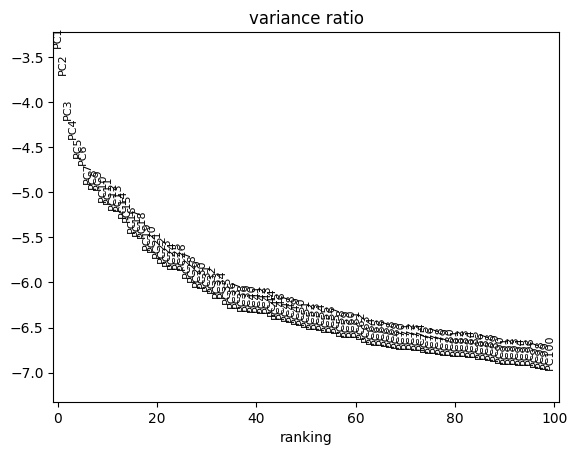

In [26]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [27]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 445 ms, sys: 324 ms, total: 769 ms
Wall time: 768 ms


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 10.96704626083374


We have now finished the preprocessing of the data.